# Quora question pairs: training

## Import packages

In [1]:
%matplotlib inline
from __future__ import print_function
import numpy as np
import pandas as pd
import datetime, time, json
from keras.models import Model
from keras.layers import Input, TimeDistributed, Dense, Lambda, concatenate, Dropout, BatchNormalization
from keras.layers.embeddings import Embedding
from keras.regularizers import l2
from keras.callbacks import Callback, ModelCheckpoint
from keras import backend as K
from sklearn.model_selection import train_test_split
import sys
import os
import csv, datetime, time, json
from zipfile import ZipFile
from os.path import expanduser, exists
from keras.utils.data_utils import get_file
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import backend as K
from sklearn.model_selection import train_test_split
from keras.layers import LSTM

Using TensorFlow backend.


## Initialize global variables

In [2]:
# Initialize global variables
KERAS_DATASETS_DIR = os.path.expanduser('~/.keras/datasets/')
QUESTION_PAIRS_FILE_URL = 'http://qim.ec.quoracdn.net/quora_duplicate_questions.tsv'
QUESTION_PAIRS_FILE = 'quora_duplicate_questions.tsv'
GLOVE_ZIP_FILE_URL = 'http://nlp.stanford.edu/data/glove.840B.300d.zip'
GLOVE_ZIP_FILE = 'glove.840B.300d.zip'
GLOVE_FILE = 'glove.840B.300d.txt'
Q1_TRAINING_DATA_FILE = 'q1_train.npy'
Q2_TRAINING_DATA_FILE = 'q2_train.npy'
LABEL_TRAINING_DATA_FILE = 'label_train.npy'
WORD_EMBEDDING_MATRIX_FILE = 'word_embedding_matrix.npy'
NB_WORDS_DATA_FILE = 'nb_words.json'
MAX_NB_WORDS = 200000
MAX_SEQUENCE_LENGTH = 25
EMBEDDING_DIM = 300
MODEL_WEIGHTS_FILE = 'question_pairs_weights.h5'
VALIDATION_SPLIT = 0.1
TEST_SPLIT = 0.2
RNG_SEED = 13371447
NB_EPOCHS = 25
DROPOUT = 0.1
BATCH_SIZE = 32
OPTIMIZER = 'adam'

## Load the dataset, embedding matrix and word count

In [3]:
# If the dataset, embedding matrix and word count exist in the local directory
if os.path.exists(Q1_TRAINING_DATA_FILE) and os.path.exists(Q2_TRAINING_DATA_FILE) and os.path.exists(LABEL_TRAINING_DATA_FILE) and os.path.exists(NB_WORDS_DATA_FILE) and os.path.exists(WORD_EMBEDDING_MATRIX_FILE):
    # Then load them
    q1_data = np.load(open(Q1_TRAINING_DATA_FILE, 'rb'))
    q2_data = np.load(open(Q2_TRAINING_DATA_FILE, 'rb'))
    labels = np.load(open(LABEL_TRAINING_DATA_FILE, 'rb'))
    word_embedding_matrix = np.load(open(WORD_EMBEDDING_MATRIX_FILE, 'rb'))
    with open(NB_WORDS_DATA_FILE, 'r') as f:
        nb_words = json.load(f)['nb_words']
else:
    # Else download and extract questions pairs data
    if not os.path.exists(KERAS_DATASETS_DIR + QUESTION_PAIRS_FILE):
        get_file(QUESTION_PAIRS_FILE, QUESTION_PAIRS_FILE_URL)

    print("Processing", QUESTION_PAIRS_FILE)

    question1 = []
    question2 = []
    is_duplicate = []
    with open(KERAS_DATASETS_DIR + QUESTION_PAIRS_FILE, encoding='utf-8') as csvfile:
        reader = csv.DictReader(csvfile, delimiter='\t')
        for row in reader:
            question1.append(row['question1'])
            question2.append(row['question2'])
            is_duplicate.append(row['is_duplicate'])

    print('Question pairs: %d' % len(question1))

    # Build tokenized word index
    questions = question1 + question2
    tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
    tokenizer.fit_on_texts(questions)
    question1_word_sequences = tokenizer.texts_to_sequences(question1)
    question2_word_sequences = tokenizer.texts_to_sequences(question2)
    word_index = tokenizer.word_index

    print("Words in index: %d" % len(word_index))

    # Download and process GloVe embeddings
    if not os.path.exists(KERAS_DATASETS_DIR + GLOVE_ZIP_FILE):
        zipfile = ZipFile(get_file(GLOVE_ZIP_FILE, GLOVE_ZIP_FILE_URL))
        zipfile.extract(GLOVE_FILE, path=KERAS_DATASETS_DIR)

    print("Processing", GLOVE_FILE)

    embeddings_index = {}
    with open(KERAS_DATASETS_DIR + GLOVE_FILE, encoding='utf-8') as f:
        for line in f:
            values = line.split(' ')
            word = values[0]
            embedding = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = embedding

    print('Word embeddings: %d' % len(embeddings_index))

    # Prepare word embedding matrix
    nb_words = min(MAX_NB_WORDS, len(word_index))
    word_embedding_matrix = np.zeros((nb_words + 1, EMBEDDING_DIM))
    for word, i in word_index.items():
        if i > MAX_NB_WORDS:
            continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            word_embedding_matrix[i] = embedding_vector
        
    print('Null word embeddings: %d' % np.sum(np.sum(word_embedding_matrix, axis=1) == 0))

    # Prepare training data tensors
    q1_data = pad_sequences(question1_word_sequences, maxlen=MAX_SEQUENCE_LENGTH)
    q2_data = pad_sequences(question2_word_sequences, maxlen=MAX_SEQUENCE_LENGTH)
    labels = np.array(is_duplicate, dtype=int)
    print('Shape of question1 data tensor:', q1_data.shape)
    print('Shape of question2 data tensor:', q2_data.shape)
    print('Shape of label tensor:', labels.shape)

    # Persist training and configuration data to files
    np.save(open(Q1_TRAINING_DATA_FILE, 'wb'), q1_data)
    np.save(open(Q2_TRAINING_DATA_FILE, 'wb'), q2_data)
    np.save(open(LABEL_TRAINING_DATA_FILE, 'wb'), labels)
    np.save(open(WORD_EMBEDDING_MATRIX_FILE, 'wb'), word_embedding_matrix)
    with open(NB_WORDS_DATA_FILE, 'w') as f:
        json.dump({'nb_words': nb_words}, f)

## Partition the dataset into train and test sets

In [4]:
X = np.stack((q1_data, q2_data), axis=1)
y = labels

X = X[:100000]
y = y[:100000]



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SPLIT, random_state=RNG_SEED)
Q1_train = X_train[:,0]
Q2_train = X_train[:,1]
Q1_test = X_test[:,0]
Q2_test = X_test[:,1]

## Define the model

In [5]:
question1 = Input(shape=(MAX_SEQUENCE_LENGTH,))
question2 = Input(shape=(MAX_SEQUENCE_LENGTH,))

rate_drop_lstm = 0.15 + np.random.rand() * 0.25

lstm_layer = LSTM(EMBEDDING_DIM, dropout=rate_drop_lstm, recurrent_dropout=rate_drop_lstm)
embedding_layer = Embedding(nb_words + 1, 
                 EMBEDDING_DIM, 
                 weights=[word_embedding_matrix], 
                 input_length=MAX_SEQUENCE_LENGTH, 
                 trainable=False)

sequence_1_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences_1 = embedding_layer(sequence_1_input)
x1 = lstm_layer(embedded_sequences_1)

sequence_2_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences_2 = embedding_layer(sequence_2_input)
y1 = lstm_layer(embedded_sequences_2)

merged = concatenate([x1,y1])
merged = Dense(200, activation='relu')(merged)
merged = Dropout(DROPOUT)(merged)
merged = BatchNormalization()(merged)

is_duplicate = Dense(1, activation='sigmoid')(merged)

model = Model(inputs=[sequence_1_input, sequence_2_input], outputs=is_duplicate)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [6]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_3 (InputLayer)             (None, 25)            0                                            
____________________________________________________________________________________________________
input_4 (InputLayer)             (None, 25)            0                                            
____________________________________________________________________________________________________
embedding_1 (Embedding)          (None, 25, 300)       28679100    input_3[0][0]                    
                                                                   input_4[0][0]                    
____________________________________________________________________________________________________
lstm_1 (LSTM)                    (None, 300)           721200      embedding_1[0][0]       

## Train the model, checkpointing weights with best validation accuracy

In [22]:
print("Starting training at", datetime.datetime.now())
t0 = time.time()
callbacks = [ModelCheckpoint(MODEL_WEIGHTS_FILE, monitor='val_acc', save_best_only=True)]
history = model.fit([Q1_train, Q2_train],
                    y_train,
                    epochs=NB_EPOCHS,
                    validation_split=VALIDATION_SPLIT,
                    verbose=2,
                    batch_size=BATCH_SIZE,
                    callbacks=callbacks)
t1 = time.time()
print("Training ended at", datetime.datetime.now())
print("Minutes elapsed: %f" % ((t1 - t0) / 60.))

Starting training at 2017-11-23 18:48:54.530046
Train on 72000 samples, validate on 8000 samples
Epoch 1/25
1252s - loss: 0.5896 - acc: 0.6873 - val_loss: 0.5395 - val_acc: 0.7248
Epoch 2/25
1097s - loss: 0.5315 - acc: 0.7313 - val_loss: 0.5166 - val_acc: 0.7342
Epoch 3/25
1117s - loss: 0.4966 - acc: 0.7543 - val_loss: 0.5160 - val_acc: 0.7331
Epoch 4/25
1102s - loss: 0.4650 - acc: 0.7766 - val_loss: 0.4763 - val_acc: 0.7704
Epoch 5/25
1084s - loss: 0.4345 - acc: 0.7970 - val_loss: 0.4758 - val_acc: 0.7650
Epoch 6/25
1101s - loss: 0.4007 - acc: 0.8146 - val_loss: 0.4674 - val_acc: 0.7754
Epoch 7/25
1035s - loss: 0.3712 - acc: 0.8324 - val_loss: 0.4759 - val_acc: 0.7806
Epoch 8/25
954s - loss: 0.3394 - acc: 0.8492 - val_loss: 0.4826 - val_acc: 0.7817
Epoch 9/25
1131s - loss: 0.3116 - acc: 0.8623 - val_loss: 0.4948 - val_acc: 0.7776
Epoch 10/25
1135s - loss: 0.2881 - acc: 0.8757 - val_loss: 0.5204 - val_acc: 0.7729
Epoch 11/25
1098s - loss: 0.2661 - acc: 0.8861 - val_loss: 0.5466 - val_a

## Plot training and validation accuracy

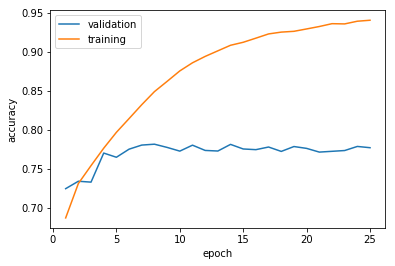

In [31]:
import matplotlib.pyplot as plt
%matplotlib inline

val_acc_list = history.history['val_acc']
train_acc_list = history.history['acc']
epoch_list = [ i + 1 for i in history.epoch ]

plt.plot(epoch_list, val_acc_list, label='validation')
plt.plot(epoch_list, train_acc_list, label='training')
#plt.plot(x, [2,5.4,3], 'r-', x, [2.2,3.4,8], 'b-', x, [1.2,0.4,5], 'y-', x ,)
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(loc='best')
plt.show()

## Print best validation accuracy and epoch

In [24]:
max_val_acc, idx = max((val, idx) for (idx, val) in enumerate(history.history['val_acc']))
print('Maximum accuracy at epoch', '{:d}'.format(idx+1), '=', '{:.4f}'.format(max_val_acc))

Maximum accuracy at epoch 8 = 0.7817


## Evaluate the model with best validation accuracy on the test partition

In [25]:
model.load_weights(MODEL_WEIGHTS_FILE)
loss, accuracy = model.evaluate([Q1_test, Q2_test], y_test, verbose=0)
print('loss = {0:.4f}, accuracy = {1:.4f}'.format(loss, accuracy))

loss = 0.4816, accuracy = 0.7814
